In [26]:
import tensorflow as tf
print(tf.__version__)


2.16.1


In [1]:
import random
import os
import glob 
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


In [2]:
# DATASET_PATH="Data/"
# TRAIN_PATH=  "Data/train/"
# TEST_PATH= "Data/test/"


import os

data_folder = "Data" 

# Function to get image paths in a specific folder
def get_image_paths(folder_path):
    image_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(".jpg"):
                image_path = os.path.join(root, file)
                image_paths.append(image_path)
    return image_paths

# Paths to train images
train_normal = get_image_paths(os.path.join(data_folder, "train", "NORMAL"))
train_covid19 = get_image_paths(os.path.join(data_folder, "train", "COVID19"))
train_pneumonia = get_image_paths(os.path.join(data_folder, "train", "PNEUMONIA"))

# Paths to test images
test_normal = get_image_paths(os.path.join(data_folder, "test", "NORMAL"))
test_covid19 = get_image_paths(os.path.join(data_folder, "test", "COVID19"))
test_pneumonia = get_image_paths(os.path.join(data_folder, "test", "PNEUMONIA"))

# Combine into train and test variables
train = {
    "NORMAL": train_normal,
    "COVID19": train_covid19,
    "PNEUMONIA": train_pneumonia
}

test = {
    "NORMAL": test_normal,
    "COVID19": test_covid19,
    "PNEUMONIA": test_pneumonia
}

# Example usage
print("Train:")
for category, paths in train.items():
    print(f"{category}: {len(paths)} images")

print("\nTest:")
for category, paths in test.items():
    print(f"{category}: {len(paths)} images")


Train:
NORMAL: 1266 images
COVID19: 460 images
PNEUMONIA: 3418 images

Test:
NORMAL: 317 images
COVID19: 116 images
PNEUMONIA: 855 images


In [3]:
import pandas as pd


# Create a DataFrame for the train set
train_data = []

for label, paths in train.items():
    for path in paths:
        train_data.append({"image_path": path, "label": label})

train_df = pd.DataFrame(train_data)

# Create a DataFrame for the test set
test_data = []

for label, paths in test.items():
    for path in paths:
        test_data.append({"image_path": path, "label": label})

test_df = pd.DataFrame(test_data)

# Encode labels
label_encoder = {"COVID19": 0, "NORMAL": 1, "PNEUMONIA": 2}

train_df["label_encoded"] = train_df["label"].map(label_encoder)
test_df["label_encoded"] = test_df["label"].map(label_encoder)

# Use frac, random_state, and reset_index for train DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Use frac, random_state, and reset_index for test DataFrame
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Example usage
print("Train DataFrame:")
print(train_df.head())

print("\nTest DataFrame:")
print(test_df.head())


Train DataFrame:
                                 image_path      label  label_encoded
0   Data\train\PNEUMONIA\PNEUMONIA(829).jpg  PNEUMONIA              2
1  Data\train\PNEUMONIA\PNEUMONIA(2424).jpg  PNEUMONIA              2
2  Data\train\PNEUMONIA\PNEUMONIA(1452).jpg  PNEUMONIA              2
3    Data\train\PNEUMONIA\PNEUMONIA(52).jpg  PNEUMONIA              2
4         Data\train\NORMAL\NORMAL(422).jpg     NORMAL              1

Test DataFrame:
                                image_path      label  label_encoded
0  Data\test\PNEUMONIA\PNEUMONIA(4105).jpg  PNEUMONIA              2
1  Data\test\PNEUMONIA\PNEUMONIA(4170).jpg  PNEUMONIA              2
2  Data\test\PNEUMONIA\PNEUMONIA(3447).jpg  PNEUMONIA              2
3        Data\test\NORMAL\NORMAL(1347).jpg     NORMAL              1
4        Data\test\NORMAL\NORMAL(1329).jpg     NORMAL              1


In [4]:
class CFG:
    EPOCHS= 50
    BATCH_SIZE= 64
    SEED= 42
    TF_SEED= 768
    HEIGHT= 224
    WIDTH= 224
    CHANNELS= 3
    IMAGE_SIZE=(224,224,3)

In [5]:
from PIL import Image


def _load(image_path):
    # Read the image using PIL
    image_pil = Image.open(image_path)
    
    # Convert the image to a NumPy array
    image_np = np.array(image_pil)
    
    # Resize the image using PIL
    resized_image = Image.fromarray(image_np).resize((CFG.IMAGE_SIZE[0], CFG.IMAGE_SIZE[1]), resample=Image.LANCZOS)
    
    return resized_image


In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def view_sample(image, label, color_map='rgb', fig_size=(6, 4)):
    plt.figure(figsize=fig_size)
    
    if color_map == 'rgb':
        plt.imshow(np.array(image))
    else:
        grayscale_image = image.convert('L')  # Convert to grayscale using PIL
        plt.imshow(grayscale_image, cmap=color_map)
    
    plt.title(f'label: {label}', fontsize=16)
    return


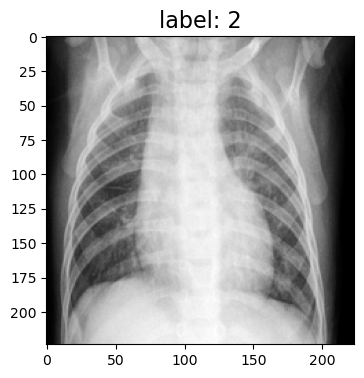

In [7]:
#select random sample from train_df
idx= random.sample(train_df.index.to_list(),1)[0]
#load the random sample and label
#sample_image, sample_label= _load(train_df.image_path[idx])
sample_image = _load(train_df.image_path[idx])
sample_label = train_df.label_encoded[idx]

#view the random sample colormap= gray
view_sample(sample_image, sample_label, color_map='gray')

In [8]:
def view_multiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
    rows = count // 5
    if rows % 5 > 0:
        rows += 1
    idx = random.sample(df.index.to_list(), count)
    fig = plt.figure(figsize=fig_size)
    
    for column, i in enumerate(idx):
        plt.subplot(rows, 5, column + 1)
        plt.title(f'Label: {df.label[i]}')
        
        loaded_image = sample_loader(df.image_path[i])
        if color_map == 'rgb':
            plt.imshow(np.array(loaded_image))
        else:
            grayscale_image = loaded_image.convert('L')  # Convert to grayscale using PIL
            plt.imshow(grayscale_image, cmap=color_map)
    
    return


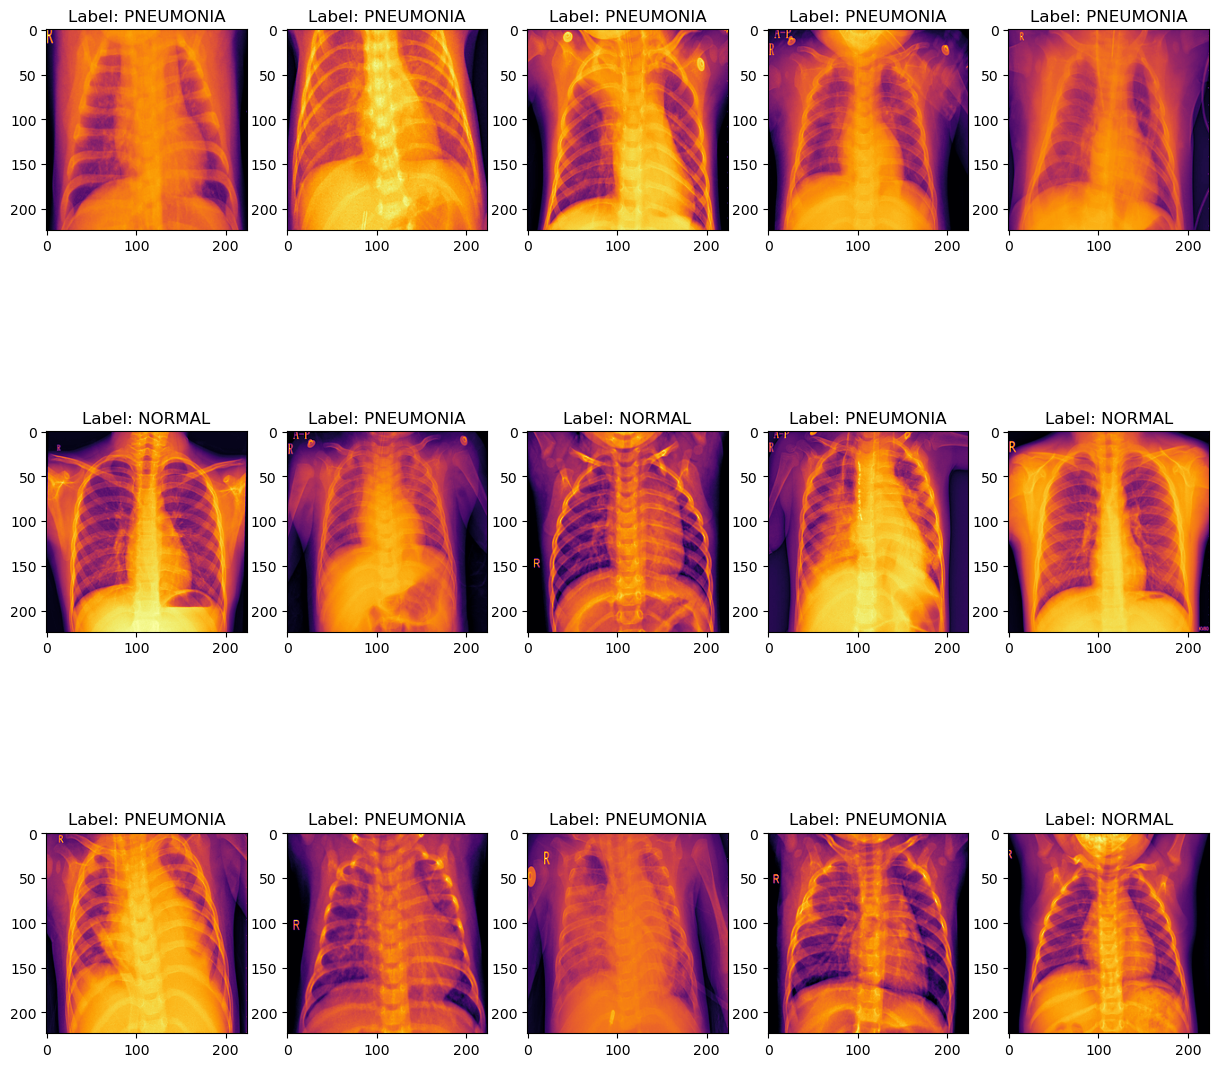

In [9]:
view_multiple_samples(train_df, _load, count=15, color_map='inferno', fig_size=(15,20))

In [10]:
from sklearn.model_selection import train_test_split


In [11]:
#create train/ val split with training
train_split_idx, val_split_idx,_,_= train_test_split(train_df.index,
                                                    train_df.label_encoded,
                                                    test_size= 0.15,
                                                    stratify=train_df.label_encoded,
                                                    random_state= CFG.SEED)

In [12]:

train_new_df= train_df.iloc[train_split_idx].reset_index(drop=True)
val_df= train_df.iloc[val_split_idx].reset_index(drop=True)
#view shape
train_new_df.shape, val_df.shape
train_new_df

,image_path,label,label_encoded
0,Data\train\PNEUMONIA\PNEUMONIA(1871).jpg,PNEUMONIA,2
1,Data\train\PNEUMONIA\PNEUMONIA(2404).jpg,PNEUMONIA,2
2,Data\train\PNEUMONIA\PNEUMONIA(335).jpg,PNEUMONIA,2
3,Data\train\PNEUMONIA\PNEUMONIA(1553).jpg,PNEUMONIA,2
4,Data\train\NORMAL\NORMAL(1152).jpg,NORMAL,1
...,...,...,...
4367,Data\train\PNEUMONIA\PNEUMONIA(1102).jpg,PNEUMONIA,2
4368,Data\train\PNEUMONIA\PNEUMONIA(3367).jpg,PNEUMONIA,2
4369,Data\train\NORMAL\NORMAL(1104).jpg,NORMAL,1
4370,Data\train\COVID19\COVID19(236).jpg,COVID19,0


In [13]:

from tensorflow.keras import layers,Sequential

#Build Augmentation layer
augmentation_layer= Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical',seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-.01,0.1),width_factor=(-0.1,0.1),seed=CFG.TF_SEED)
],name= 'augmentation_layer')

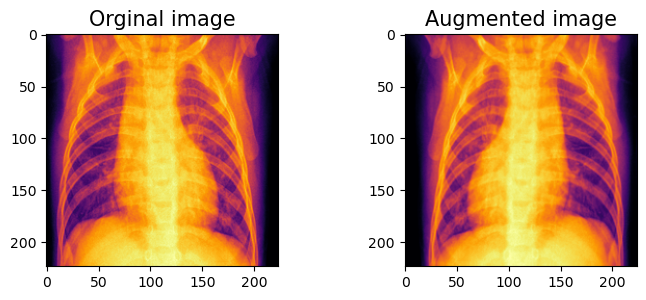

In [14]:
# Show inferno Augmented Image

image= tf.image.rgb_to_grayscale(sample_image)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,6))
#set spacing between subplot
fig.tight_layout(pad=6.0)
#view orginal image
ax1.set_title('Orginal image',fontsize=15)
ax1.imshow(image,cmap='inferno')
#view augmented image
ax2.set_title('Augmented image',fontsize=15)
ax2.imshow(augmentation_layer(image),cmap='inferno')

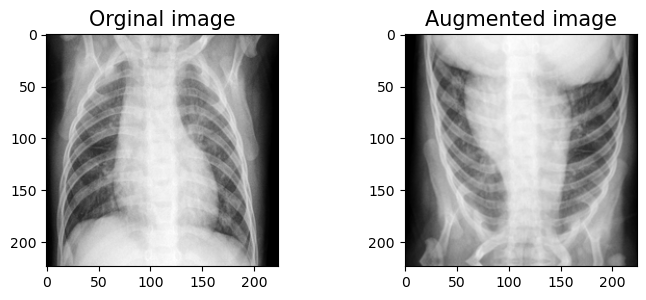

In [15]:
# Show Gray Augmented Image

image= tf.image.rgb_to_grayscale(sample_image)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,6))
#set spacing between subplot
fig.tight_layout(pad=6.0)
#view orginal image
ax1.set_title('Orginal image',fontsize=15)
ax1.imshow(image,cmap='gray')
#view augmented image
ax2.set_title('Augmented image',fontsize=15)
ax2.imshow(augmentation_layer(image),cmap='gray')

In [16]:
train_new_df

,image_path,label,label_encoded
0,Data\train\PNEUMONIA\PNEUMONIA(1871).jpg,PNEUMONIA,2
1,Data\train\PNEUMONIA\PNEUMONIA(2404).jpg,PNEUMONIA,2
2,Data\train\PNEUMONIA\PNEUMONIA(335).jpg,PNEUMONIA,2
3,Data\train\PNEUMONIA\PNEUMONIA(1553).jpg,PNEUMONIA,2
4,Data\train\NORMAL\NORMAL(1152).jpg,NORMAL,1
...,...,...,...
4367,Data\train\PNEUMONIA\PNEUMONIA(1102).jpg,PNEUMONIA,2
4368,Data\train\PNEUMONIA\PNEUMONIA(3367).jpg,PNEUMONIA,2
4369,Data\train\NORMAL\NORMAL(1104).jpg,NORMAL,1
4370,Data\train\COVID19\COVID19(236).jpg,COVID19,0


In [17]:
def encode_labels(labels,encode_depth=3):
    return tf.one_hot(labels,depth=encode_depth).numpy()
def create_pipeline(df,load_function,augment=False,batch_size=32,shuffle=False,cache=None,prefetch=False):
    #get image path and labels from data_frame
    image_paths= df.image_path
    image_labels= encode_labels(df.label_encoded)
    AUTOTUNE= tf.data.AUTOTUNE
    #Create dataset with raw data from data frame
    ds= tf.data.Dataset.from_tensor_slices((image_paths,image_labels))
    #map augmentation layer and load function to dataset input if augment is true
    if augment:
        ds=ds.map(lambda x,y: (augmentation_layer(load_function(x)),y),num_parallel_calls= AUTOTUNE)
    else:
        ds= ds.map(lambda x,y: (load_function(x),y),num_parallel_calls= AUTOTUNE)
    #Applying shuffing based on condion
    if shuffle:
        ds= ds.shuffle(buffer_size=1000)
    #applying batching
    ds= ds.batch(batch_size)
    #applying caching based on condion
    if cache!=None:
        ds= ds.cache(cache)
    if prefetch:
        ds= ds.prefetch(buffer_size= AUTOTUNE)
    return ds

In [18]:
def _load(image_path):
    # Read the image from the file
    image = tf.io.read_file(image_path)
    # Decode the image to a uint8 tensor
    image = tf.io.decode_image(image, channels=3)
    # Ensure the image has a known shape
    image.set_shape([CFG.HEIGHT, CFG.WIDTH, 3])
    # Resize the image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH], method=tf.image.ResizeMethod.LANCZOS3)
    return image

In [19]:
#Creating Training Pipeline
train_ds= create_pipeline(train_new_df,_load,
                         augment= True,
                         batch_size= CFG.BATCH_SIZE,
                         shuffle=False, prefetch= True)

In [20]:
train_ds


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [31]:
#Creating Validation Pipeline
val_ds= create_pipeline(val_df,_load,
                         
                         batch_size= CFG.BATCH_SIZE,
                         shuffle=False, prefetch= False)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the ConvNeXt block
def conv_next_block(inputs, filters, dropout_rate=0.):
    x = layers.Conv2D(filters, kernel_size=7, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)
    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    return layers.Add()([inputs, x])

# Build the ConvNeXt model
def build_convnext_model(input_shape, num_classes, depths, dim, dropout_rate=0.1):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(dim, kernel_size=4, strides=4, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)

    for depth in depths:
        x = conv_next_block(x, dim, dropout_rate)
        for _ in range(depth):
            x = conv_next_block(x, dim, dropout_rate)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

# Assuming you have already created the data pipelines: train_ds, val_ds, test_ds

# Define the ConvNeXt model
input_shape = (CFG.HEIGHT, CFG.WIDTH, CFG.CHANNELS)
num_classes = 3  # Number of classes (COVID19, NORMAL, PNEUMONIA)
depths = [3, 3, 9, 3]  # Depth configuration for ConvNeXt
dim = 96  # Dimension of the model

model = build_convnext_model(input_shape, num_classes, depths, dim)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
# Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=CFG.EPOCHS,
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2366s 34s/step - accuracy: 0.6771 - loss: 1.6130 - val_accuracy: 0.2474 - val_loss: 257.7867
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2352s 34s/step - accuracy: 0.7445 - loss: 0.6089 - val_accuracy: 0.3834 - val_loss: 4.8589
Epoch 3/50
 1/69 ━━━━━━━━━━━━━━━━━━━━ 37:12 33s/step - accuracy: 0.7188 - loss: 0.6021